# Credit Default Risk prediction

# Packages

Let's first import all the packages that I'll be using during this project.

* numpy is the main package for scientific computing with Python.
* pandas is a library for data manipulation and analysis.
* LabelEncoder is used to encode the object datatypes.
* Matplotlib and Seaborn are for visualization purposes.

In [1]:
import numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import Imputer, PolynomialFeatures, MinMaxScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Dataset 

Here I am importing the train and test datasets provided.

In [2]:
app_train = pd.read_csv('../input/application_train.csv')
app_test = pd.read_csv('../input/application_test.csv')

print('Shape of training set: {}'.format(app_train.shape))
print('Shape of testing set: {}'.format(app_test.shape))

Shape of training set: (307511, 122)
Shape of testing set: (48744, 121)


First let's see what our dataset is actually made of so that we can take appropriate actions.

In [3]:
app_train.columns[2:].values

array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASE

In [4]:
app_train.head(n=10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,NaN,1,1,1,1,1,0,Laborers,2.0,2,2,WEDNESDAY,16,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-2536.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130,-1213.0,-619,17.0,1,1,0,1,1,0,Acco

# Handle the unbalanced dataset

In [5]:
x = app_train['TARGET'].value_counts()
print('{}% are zeros and {}% are ones'.format(round(100 * x[0] / app_train.shape[0], 2), round(100 - 100 * x[0] / app_train.shape[0], 2)))

91.93% are zeros and 8.07% are ones


**Random Under-Sampling**

Random Undersampling aims to balance class distribution by randomly eliminating majority class examples.  This is done until the majority and minority class instances are balanced out.

* Advantages: 
It can help improve run time and storage problems by reducing the number of training data samples when the training data set is huge.

* Disadvantages: 
It can discard potentially useful information which could be important for building rule classifiers.
The sample chosen by random under sampling may be a biased sample. And it will not be an accurate representative of the population. Thereby, resulting in inaccurate results with the actual test data set.

In [6]:
app_train = app_train.sample(frac=1).reset_index(drop=True)
zeros = app_train.loc[app_train['TARGET'] == 0]
ones = app_train.loc[app_train['TARGET'] == 1]
zeros = zeros[1:int(zeros.shape[0]*0.7)]
app_train_b = zeros.append(ones, ignore_index=True)
app_train_b = app_train_b.sample(frac=1).reset_index(drop=True)
print('{}% are zeros and {}% are ones'.format(round(100 * zeros.shape[0] / app_train_b.shape[0], 2), round(100 - 100 * zeros.shape[0] / app_train_b.shape[0], 2)))
print('Out of {} examples {} got deleted.'.format(app_train.shape[0], app_train.shape[0] - app_train_b.shape[0]))

88.85% are zeros and 11.15% are ones
Out of 307511 examples 84807 got deleted.


**Random Over-Sampling**

Over-Sampling increases the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the sample.

* Advantages: 
Unlike under sampling this method leads to no information loss.
Outperforms under sampling

* Disadvantages: 
It increases the likelihood of overfitting since it replicates the minority class events.

In [7]:
app_train_b = app_train_b.append(ones[1:int(ones.shape[0]*0.5)], ignore_index=True)
app_train_b = app_train_b.sample(frac=1).reset_index(drop=True)
print('{}% are zeros and {}% are ones'.format(round(100 * zeros.shape[0] / app_train_b.shape[0], 2), round(100 - 100 * zeros.shape[0] / app_train_b.shape[0], 2)))
print('Shape of new training dataset is: {}'.format(app_train_b.shape))

84.16% are zeros and 15.84% are ones
Shape of new training dataset is: (235115, 122)


In [8]:
app_train_b.head(n=10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,138548,0,Revolving loans,M,N,Y,0,180000.0,292500.0,14625.0,292500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.014520,-8566,-920,-2258.0,-479,NaN,1,1,0,1,0,0,IT staff,2.0,2,2,SUNDAY,11,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,206966,1,Cash loans,F,N,Y,0,157500.0,450000.0,32877.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,Co-op apartment,0.031329,-8133,-1211,-8102.0,-285,NaN,1,1,0,1,1,0,Medicine staff,2.0,2,2,SUNDAY,15,0,0,0,0,0,0,...,NaN,0.0069,NaN,NaN,NaN,NaN,0.0053,NaN,No,1.0,1.0,1.0,1.0,-1010.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,145706,0,Cash loans,F,N,Y,0,76500.0,99504.0,10845.0,90000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.004849,-21963,365243,-6053.0,-5088,NaN,1,0,0,1,1,0,NaN,1.0,2,2,MONDAY,11,0,0,0,0,0,0,...,0.1231,0.1549,0.0078,0.0022,reg oper account,block of flats,0.1202,Panel,No,3.0,0.0,3.0,0.0,-2191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,151568,0,Cash loans,F,Y,Y,0,180000.0,265536.0,13684.5,180000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.030755,-14277,-119,-5011.0,-4438,24.0,1,1,0,1,0,1,Managers,1.0,2,2,THURSDAY,12,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,-840.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,388840,0,Cash loans,F,N,Y,0,135000.0,595912.5,40113.0,562500.0,Unaccompanied,Pensioner,Lower secondary,Married,House / apartment,0.019101,-23107,365243,-10650.0,-4319,NaN,1,0,0,1,0,0,NaN,2.0,2,2,MONDAY,10,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,6.0,0.0,-643.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,352758,1,Cash loans,F,N,N,1,225000.0,912240.0,48730.5,787500.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.014464,-16389,-147,-3002.0,-2878,NaN,1,1,0,1,0,0,Core staff,3.0,2,2,THURSDAY,11,0,0,0,0,0,0,...,NaN,0.0072,NaN,NaN,NaN,block of flats,0.0074,Wooden,Yes,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
6,241542,0,Cash loans,F,N,Y,0,90000.0,1016496.0,33592.5,877500.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.009630,-19388,365243,-1563.0,-2362,NaN,1,0,0,1,0,0,NaN,2.0,2,2,THURSDAY,10,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0

# Encoding

In [9]:
app_train_b.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [10]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train_b[col].unique())) <= 2:
            le.fit(app_train_b[col])
            app_train_b[col] = le.transform(app_train_b[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1

app_train_b = pd.get_dummies(app_train_b)
app_test = pd.get_dummies(app_test)

train_labels = app_train_b['TARGET']
app_train_b, app_test = app_train_b.align(app_test, join = 'inner', axis = 1)
app_train_b['TARGET'] = train_labels

print('Training Features shape: {}'.format(app_train_b.shape))
print('Testing Features shape: {}'.format(app_test.shape))

Training Features shape: (235115, 240)
Testing Features shape: (48744, 239)


In [11]:
app_train_b.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,138548,1,0,1,0,180000.0,292500.0,14625.0,292500.0,0.014520,-8566,-920,-2258.0,-479,NaN,1,1,0,1,0,0,2.0,2,2,11,0,0,0,0,0,0,0.273476,0.300796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,206966,0,0,1,0,157500.0,450000.0,32877.0,450000.0,0.031329,-8133,-1211,-8102.0,-285,NaN,1,1,0,1,1,0,2.0,2,2,15,0,0,0,0,0,0,0.183456,0.524430,NaN,NaN,NaN,0.9707,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,145706,0,0,1,0,76500.0,99504.0,10845.0,90000.0,0.004849,-21963,365243,-6053.0,-5088,NaN,1,0,0,1,1,0,1.0,2,2,11,0,0,0,0,0,0,NaN,0.456345,0.622922,0.1505,0.1088,0.9856,0.7960,0.0298,0.16,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,151568,0,1,1,0,180000.0,265536.0,13684.5,180000.0,0.030755,-14277,-119,-5011.0,-4438,24.0,1,1,0,1,0,1,1.0,2,2,12,0,0,0,0,1,1,0.585540,0.601943,0.746300,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,388840,0,0,1,0,135000.0,595912.5,40113.0,562500.0,0.019101,-23107,365243,-10650.0,-4319,NaN,1,0,0,1,0,0,2.0,2,2,10,0,0,0,0,0,0,NaN,0.609755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,352758,0,0,0,1,225000.0,912240.0,48730.5,787500.0,0.014464,-16389,-147,-3002.0,-2878,NaN,1,1,0,1,0,0,3.0,2,2,11,0,0,0,0,0,0,0.517458,0.444259,0.683269,NaN,NaN,0.9608,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1
6,241542,0,0,1,0,90000.0,1016496.0,33592.5,877500.0,0.009630,-19388,365243,-1563.0,-2362,NaN,1,0,0,1,0,0,2.0,2,2,10,0,0,0,0,0,0,NaN,0.545318,0.597192,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,196770,0,0,1,0,135000.0,704844.0,36117.0,630000.0,0.010032,-16321,-1516,-1807.0,-4412,NaN,1,1,0,1,0,0,1.0,2,2,8,0,0,0,0,1,1,NaN,0.554719,NaN,0.0804,0.0866,0.9826,0.7620,0.0118,0.00,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
8,148983,0,1,1,1,180000.0,13477

# Look for missing values

In [12]:
mis_val = app_train_b.isnull().sum()
mis_val_percent = 100 * app_train_b.isnull().sum() / len(app_train_b)
mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
mis_val_table_ren_columns = mis_val_table_ren_columns[
mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
print ('Out of {} columns {} have missing values'.format(app_train_b.shape[1], mis_val_table_ren_columns.shape[0]))
mis_val_table_ren_columns.head(n=20)

Out of 240 columns 60 have missing values


,Missing Values,% of Total Values
COMMONAREA_MEDI,165081,70.2
COMMONAREA_AVG,165081,70.2
COMMONAREA_MODE,165081,70.2
NONLIVINGAPARTMENTS_MODE,164089,69.8
NONLIVINGAPARTMENTS_AVG,164089,69.8
NONLIVINGAPARTMENTS_MEDI,164089,69.8
LIVINGAPARTMENTS_AVG,161592,68.7
LIVINGAPARTMENTS_MODE,161592,68.7
LIVINGAPARTMENTS_MEDI,161592,68.7
FLOORSMIN_MEDI,160391,68.2


# Detect and Remove Anomalies

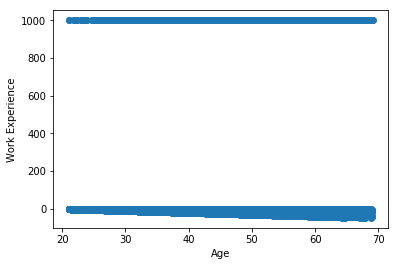

In [13]:
plt.scatter(app_train_b['DAYS_BIRTH']/-365, app_train_b['DAYS_EMPLOYED']/365)
plt.xlabel('Age')
plt.ylabel('Work Experience')
plt.show()

From the above plot we can conclude that this dataset counts the work experience of past life(that'd be great) **OR** there are anomalies in DAYS_EMPLOYED dataset.

So now we'll try to remove those anomalies.

In [14]:
app_train_b['DAYS_EMPLOYED'].describe()

count    235115.000000
mean      62130.535517
std      139799.958022
min      -17546.000000
25%       -2709.000000
50%       -1194.000000
75%        -297.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

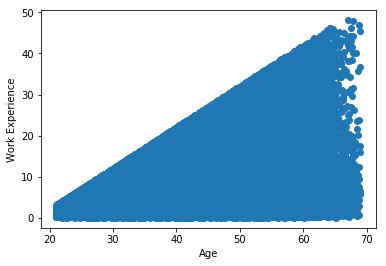

In [15]:
app_train_b['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

plt.scatter(app_train_b['DAYS_BIRTH']/-365, app_train_b['DAYS_EMPLOYED']/-365)
plt.xlabel('Age')
plt.ylabel('Work Experience')
plt.show()

This plot is much more inline with what we'd expect compared to the previous one.

# Correlations

In [16]:
correlations = app_train_b.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 REG_CITY_NOT_WORK_CITY         0.069198
CODE_GENDER_M                  0.073856
DAYS_LAST_PHONE_CHANGE         0.074445
NAME_INCOME_TYPE_Working       0.078557
REGION_RATING_CLIENT           0.079162
REGION_RATING_CLIENT_W_CITY    0.081656
DAYS_EMPLOYED                  0.100915
DAYS_BIRTH                     0.107690
TARGET                         1.000000
FLAG_DOCUMENT_12                    NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                           -0.236729
EXT_SOURCE_2                           -0.210315
EXT_SOURCE_1                           -0.208438
NAME_EDUCATION_TYPE_Higher education   -0.075953
CODE_GENDER_F                          -0.073840
NAME_INCOME_TYPE_Pensioner             -0.063973
ORGANIZATION_TYPE_XNA                  -0.063665
FLOORSMAX_AVG                          -0.058261
FLOORSMAX_MEDI                         -0.057871
FLOORSMAX_MODE                         -0.056861
Name: TARGET, dtype: f

After looking at the above data we can conclude that DAYS_BIRTH, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 are the correlations which affect the TARGET the most. Now we are going to look deeper in these correlations.

In [17]:
app_train_b['DAYS_BIRTH'] = abs(app_train_b['DAYS_BIRTH'])
ext_data = app_train_b[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.208438,-0.210315,-0.236729,-0.107690
EXT_SOURCE_1,-0.208438,1.000000,0.226059,0.202358,0.600958
EXT_SOURCE_2,-0.210315,0.226059,1.000000,0.127803,0.103313
EXT_SOURCE_3,-0.236729,0.202358,0.127803,1.000000,0.212677
DAYS_BIRTH,-0.107690,0.600958,0.103313,0.212677,1.000000


All three EXT_SOURCE features have negative correlations with the TARGET, indicating that as the value of the EXT_SOURCE increases

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


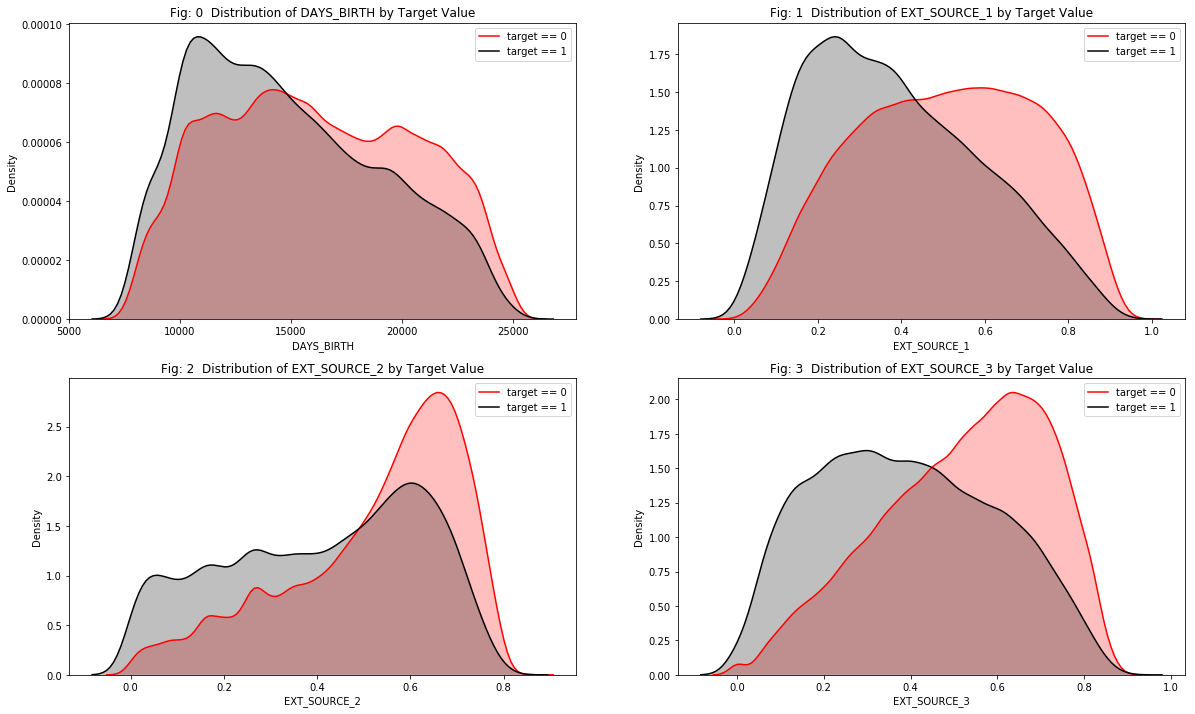

In [18]:
plt.figure(figsize = (20, 12))
for i, source in enumerate(['DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(app_train_b.loc[app_train_b['TARGET'] == 0, source], label = 'target == 0', color='r', shade=True)
    sns.kdeplot(app_train_b.loc[app_train_b['TARGET'] == 1, source], label = 'target == 1', color='k', shade=True)
    plt.title('Fig: ' + str(i) + '  Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Density')

Out of the above 4 plots the most interesting ones are distributions with DAYS_BIRTH and EXT_SOURCE_3. They show some pretty interesting properties.

**Plot 0 :  DAYS_BIRTH**

In this plot we can see that target 1 plot skews towards the young generation which means that younger people tend to default on their credit bills.

**Plot 3 :  EXT_SOURCE_3**

In this plot we can see that EXT_SOURCE_3 is in direct correlation with TARGET. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan.

# Feature Engineering

Now that we have come down to 4 features. Let's construct some more features of our own using the existing data. I'll take copies of the original dataset and neature engineered datasets to see whether they help in increasing accuracy or not.

## Polynomial Features - 

In this method, we make features that are powers of existing features as well as interaction terms between existing features.

In [19]:
poly_features = app_train_b[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]

imputer = Imputer(strategy = 'median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

poly_features = imputer.fit_transform(poly_features)

poly_transformer = PolynomialFeatures(degree = 3)

poly_transformer.fit(poly_features)
app_train_poly = pd.DataFrame(poly_transformer.transform(poly_features))
app_train_poly.columns = poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Dealing with missing values in main dataset

In [20]:
X_train = app_train_b.drop(columns = ['TARGET'])
Y_train = app_train_b['TARGET']
features = list(X_train.columns)
imputer = Imputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(X_train)
X_train = imputer.transform(X_train)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print("X_train's shape: {}".format(X_train.shape))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


X_train's shape: (235115, 239)


# Logistic Regression model

In [21]:
reg = LogisticRegression(C = 0.001, solver='lbfgs')
reg.fit(X_train, Y_train)
cv = cross_val_score(reg, X_train, Y_train, cv=5)
print('Accuracy: {}%'.format(cv.mean() * 100))

Accuracy: 84.21495872485364%


# Random Forest model

In [22]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
cv = cross_val_score(rf, X_train, Y_train, cv=5)
print('Accuracy: {}%'.format(cv.mean() * 100))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 91.02736961061382%


# Dealing with missing values in feature engineered dataset

In [23]:
X_train_poly = app_train_poly
Y_train_poly = Y_train
features = list(X_train_poly.columns)
imputer = Imputer(strategy = 'median')
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(X_train_poly)
X_train_poly = imputer.transform(X_train_poly)
scaler.fit(X_train_poly)
X_train_poly = scaler.transform(X_train_poly)
print("X_train's shape: {}".format(X_train_poly.shape))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


X_train's shape: (235115, 35)


# Logistic Regression

In [24]:
reg = LogisticRegression(C = 0.001, solver='lbfgs')
reg.fit(X_train_poly, Y_train_poly)
cv = cross_val_score(reg, X_train_poly, Y_train_poly, cv=5)
print('Accuracy: {}%'.format(cv.mean() * 100))

Accuracy: 84.16774772220656%


# Random Forest

In [25]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
cv = cross_val_score(rf, X_train, Y_train, cv=5)
print('Accuracy: {}%'.format(cv.mean() * 100))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 91.05501513155161%


Well... Feature engineering didn't help us at all. I wonder why.. I'll do some more research on this and then upload the new model soon. For now, the Random Forest Classifier is giving is 91% accuracy which is pretty darn good for a quick model.